In [92]:
# Import classic libraries (Matplotlib and PyLab)
%matplotlib inline
%pylab inline

#Sklearn Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import joblib # library to save skelearn models

# Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision
from torchsummary import summary


import pandas as pd
import numpy as np
import sys
import os 


# Parameters (figure size and random seed)
pylab.rcParams['figure.figsize'] = (15,15)

Populating the interactive namespace from numpy and matplotlib


In [71]:
# For colab
IN_COLAB = 'google.colab' in sys.modules
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd "/content/gdrive/MyDrive/IMT Atlantique/Data Science/Project Bycicle/bikes-theft-model/MLP_Network"



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/IMT Atlantique/Data Science/Project Bycicle/bikes-theft-model/MLP_Network


In [217]:
bicyTheft_df = pd.read_csv('/content/gdrive/MyDrive/IMT Atlantique/Data Science/Project Bycicle/bikes-theft-model/Data/census_theft_data.csv',header=0, dtype = {"GeoUID":str})

In [219]:
bicyTheft_df = bicyTheft_df[bicyTheft_df['GeoUID'].notnull()]
Geo = ['5350062.02', '5350011.00', '5350066.00', '5350012.04', '5350012.01',
 '5350016.00', '5350014.00', '5350032.00', '5350037.00', '5350017.00',
 '5350062.01', '5350010.02', '5350092.00', '5350008.01', '5350034.02',
 '5350091.01', '5350035.00', '5350089.00', '5350038.00', '5350044.00',
 '5350013.01', '5350012.03', '5350064.00', '5350013.02', '5350061.00',
 '5350015.00', '5350008.02']
bicyTheft_df = bicyTheft_df[bicyTheft_df['GeoUID'].apply(lambda x: x in Geo)]
bicyTheft_df.replace({ -np.inf : np.nan, np.inf: np.nan, 'None': np.nan}, inplace=True)


In [185]:
print(bicyTheft_df.info())
bicyTheft_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 7 to 110
Data columns (total 61 columns):
 #   Column                                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                                              --------------  -----  
 0   GeoUID                                                                                                                                              27 non-null     object 
 1   Type                                                                                                                                                27 non-null     object 
 2   Region Name                                                                                                                                         27 non-null     object 
 3   Area (

,Area (sq km),Population,Dwellings,Households,v_CA16_5005: Total - Income statistics in 2015 for persons aged 15 years and over not in economic families in private households - 25% sample data,v_CA16_3852: Total - Aboriginal identity for the population in private households - 25% sample data,v_CA16_3999: Total - Ethnic origin for the population in private households - 25% sample data,v_CA16_3438: Total - Age at immigration for the immigrant population in private households - 25% sample data,v_CA16_3390: Total - Citizenship for the population in private households - 25% sample data,"v_CA16_5096: Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data","v_CA16_5051: Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",v_CA16_5621: Total population aged 15 years and over by work activity during the reference year - 25% sample data,v_CA16_5762: Total - Place of work status for the employed labour force aged 15 years and over in private households - 25% sample data,v_CA16_5807: Bicycle,v_CA16_5807: Bicycle.1,v_CA16_388: 15 to 64 years,v_CA16_418: Private households by household size,v_CA16_406: Population density per square kilometre,v_CA16_424: Number of persons in private households,v_CA16_478: Total - Census families in private households by family size - 100% data,v_CA16_485: Total couple families,v_CA16_491: Total - Couple census families in private households - 100% data,v_CA16_501: Total - Persons not in census families in private households - 100% data,v_CA16_509: Non-census-family households,v_CA16_504: Total - Private households by household type - 100% data,v_CA16_2201: Total - Income statistics in 2015 for the population aged 15 years and over in private households - 100% data,v_CA16_2246: Total - Total income groups in 2015 for the population aged 15 years and over in private households - 100% data,v_CA16_2297: Total - After-tax income groups in 2015 for the population aged 15 years and over in private households - 100% data,v_CA16_2351: With employment income,v_CA16_2396: Total - Income statistics in 2015 for private households by household size - 100% data,"v_CA16_2406: Under $5,000","v_CA16_2407: $5,000 to $9,999","v_CA16_2408: $10,000 to $14,999","v_CA16_2416: $50,000 to $59,999","v_CA16_2417: $60,000 to $69,999","v_CA16_2418: $70,000 to $79,999","v_CA16_2419: $80,000 to $89,999","v_CA16_2420: $90,000 to $99,999",v_CA16_2465: Median total income in 2015 for persons aged 15 years and over not in economic families ($),v_CA16_2510: Total - Low-income status in 2015 for the population in private households to whom low-income concepts are applicable - 100% data,"v_CA16_2525: In low income based on the Low-income measure, after tax (LIM-AT)","v_CA16_2555: In low income based on the Low-income cut-offs, after tax (LICO-AT)","v_CA16_2570: Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)",Total_Theft_Bikes_in_2014-04-14,Total_Theft_Bikes_in_2014-04-21,Total_Theft_Bikes_in_2014-04-28,Total_Theft_Bikes_in_2014-05-05,Total_Theft_Bikes_in_2014-05-12,Cost_of_Bike_in_2014-04-14,Cost_of_Bike_in_2014-04-21,Cost_of_Bike_in_2014-04-28,Cost_of_Bike_in_2014-05-05,Cost_of_Bike_in_2014-05-12,Density_Theft_Bikes_in_2014-04-14/Area,Density_Theft_Bikes_in_2014-04-21/Area,Density_Theft_Bikes_in_2014-04-28/Area,Density_Theft_Bikes_in_2014-05-05/Area,Density_Theft_Bikes_in_2014-05-12/Area
count,27.000000,27.00000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,2

Preprocessing Data

In [206]:
''' Importan function to metrics evaluation '''
def metrics_evaluation_prediction(model, X_test, y_test, to_tensor = False):
    if to_tensor:
        X_test = torch.from_numpy(X_test.values).float()
        X_test = X_test.to(device, dtype=torch.float32)

        with torch.no_grad():
            y_pred = model.forward(X_test)
        
        y_pred = y_pred.to("cpu").numpy()
    else:
        y_pred = model.predict(X_test)
        print(y_pred)

    y_pred = pd.DataFrame(y_pred)
    y_pred.rename(columns= {0 : 'Density_Theft_Bikes_in_2014-04-14/Area', 1 : 'Density_Theft_Bikes_in_2014-04-21/Area', 2 : 'Density_Theft_Bikes_in_2014-04-28/Area', 3 : 'Density_Theft_Bikes_in_2014-05-05/Area', 4 : 'Density_Theft_Bikes_in_2014-05-12/Area'}, inplace= True)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    return y_pred


In [199]:
bicyTheft_df = bicyTheft_df.drop(columns= ['Households ',
 'v_CA16_3999: Total - Ethnic origin for the population in private households - 25% sample data',
 'v_CA16_3390: Total - Citizenship for the population in private households - 25% sample data',
 'v_CA16_5096: Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data',
 'v_CA16_5051: Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data',
 'v_CA16_5621: Total population aged 15 years and over by work activity during the reference year - 25% sample data',
 'v_CA16_5807: Bicycle.1',
 'v_CA16_418: Private households by household size',
 'v_CA16_424: Number of persons in private households',
 'v_CA16_491: Total - Couple census families in private households - 100% data',
 'v_CA16_504: Total - Private households by household type - 100% data',
 'v_CA16_2201: Total - Income statistics in 2015 for the population aged 15 years and over in private households - 100% data',
 'v_CA16_2246: Total - Total income groups in 2015 for the population aged 15 years and over in private households - 100% data',
 'v_CA16_2297: Total - After-tax income groups in 2015 for the population aged 15 years and over in private households - 100% data',
 'v_CA16_2351: With employment income',
 'v_CA16_2396: Total - Income statistics in 2015 for private households by household size - 100% data',
 'v_CA16_2510: Total - Low-income status in 2015 for the population in private households to whom low-income concepts are applicable - 100% data',
 'v_CA16_2555: In low income based on the Low-income cut-offs, after tax (LICO-AT)'])

In [220]:
# Split columns in ratio and categorical type
cat_columns = ['Type', 'Region Name']


ratio_columns = [x for x in bicyTheft_df.columns if x not in cat_columns]

# Standard ratio variables
std_scale = StandardScaler().fit(bicyTheft_df[ratio_columns])
bicyTheft_df[ratio_columns] = std_scale.transform(bicyTheft_df[ratio_columns])
display(bicyTheft_df.head())
display(bicyTheft_df[ratio_columns].describe())

# One-shot hot encoding
# youtube_df = pd.get_dummies(youtube_df, columns = cat_columns)
print(bicyTheft_df.shape, bicyTheft_df.columns)

,GeoUID,Type,Region Name,Area (sq km),Population,Dwellings,Households,v_CA16_5005: Total - Income statistics in 2015 for persons aged 15 years and over not in economic families in private households - 25% sample data,v_CA16_3852: Total - Aboriginal identity for the population in private households - 25% sample data,v_CA16_3999: Total - Ethnic origin for the population in private households - 25% sample data,v_CA16_3438: Total - Age at immigration for the immigrant population in private households - 25% sample data,v_CA16_3390: Total - Citizenship for the population in private households - 25% sample data,"v_CA16_5096: Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data","v_CA16_5051: Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",v_CA16_5621: Total population aged 15 years and over by work activity during the reference year - 25% sample data,v_CA16_5762: Total - Place of work status for the employed labour force aged 15 years and over in private households - 25% sample data,v_CA16_5807: Bicycle,v_CA16_5807: Bicycle.1,v_CA16_388: 15 to 64 years,v_CA16_418: Private households by household size,v_CA16_406: Population density per square kilometre,v_CA16_424: Number of persons in private households,v_CA16_478: Total - Census families in private households by family size - 100% data,v_CA16_485: Total couple families,v_CA16_491: Total - Couple census families in private households - 100% data,v_CA16_501: Total - Persons not in census families in private households - 100% data,v_CA16_509: Non-census-family households,v_CA16_504: Total - Private households by household type - 100% data,v_CA16_2201: Total - Income statistics in 2015 for the population aged 15 years and over in private households - 100% data,v_CA16_2246: Total - Total income groups in 2015 for the population aged 15 years and over in private households - 100% data,v_CA16_2297: Total - After-tax income groups in 2015 for the population aged 15 years and over in private households - 100% data,v_CA16_2351: With employment income,v_CA16_2396: Total - Income statistics in 2015 for private households by household size - 100% data,"v_CA16_2406: Under $5,000","v_CA16_2407: $5,000 to $9,999","v_CA16_2408: $10,000 to $14,999","v_CA16_2416: $50,000 to $59,999","v_CA16_2417: $60,000 to $69,999","v_CA16_2418: $70,000 to $79,999","v_CA16_2419: $80,000 to $89,999","v_CA16_2420: $90,000 to $99,999",v_CA16_2465: Median total income in 2015 for persons aged 15 years and over not in economic families ($),v_CA16_2510: Total - Low-income status in 2015 for the population in private households to whom low-income concepts are applicable - 100% data,"v_CA16_2525: In low income based on the Low-income measure, after tax (LIM-AT)","v_CA16_2555: In low income based on the Low-income cut-offs, after tax (LICO-AT)","v_CA16_2570: Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)",Total_Theft_Bikes_in_2014-04-14,Total_Theft_Bikes_in_2014-04-21,Total_Theft_Bikes_in_2014-04-28,Total_Theft_Bikes_in_2014-05-05,Total_Theft_Bikes_in_2014-05-12,Cost_of_Bike_in_2014-04-14,Cost_of_Bike_in_2014-04-21,Cost_of_Bike_in_2014-04-28,Cost_of_Bike_in_2014-05-05,Cost_of_Bike_in_2014-05-12,Density_Theft_Bikes_in_2014-04-14/Area,Density_Theft_Bikes_in_2014-04-21/Area,Density_Theft_Bikes_in_2014-04-28/Area,Density_Theft_Bikes_in_2014-05-05/Area,Density_Theft_Bikes_in_2014-05-12/Area
7,-1.021842,CT,Toronto,-0.680087,0.163485,0.204781,0.389233,0.243843,0.266673,0.266668,-0.354787,0.266639,0.664706,0.310441,0.310593,0.722476,0.516595,0.516595,1.876706,0.389737,0.961402,0.222455,0.363031,0.555664,0.557011,0.253254,0.380980,0.389533,0.264842,0.266168,0.266320,0.598411,0.389541,-0.531927,-0.524257,-0.963691,0.717682,0.748121,0.906529,1.039715,1.022502,1.163333,0.222353,-0.835302,-0.855576,-1.283918,-0.725319,1.959824,-0.539164,-0.549350,0.802

,GeoUID,Area (sq km),Population,Dwellings,Households,v_CA16_5005: Total - Income statistics in 2015 for persons aged 15 years and over not in economic families in private households - 25% sample data,v_CA16_3852: Total - Aboriginal identity for the population in private households - 25% sample data,v_CA16_3999: Total - Ethnic origin for the population in private households - 25% sample data,v_CA16_3438: Total - Age at immigration for the immigrant population in private households - 25% sample data,v_CA16_3390: Total - Citizenship for the population in private households - 25% sample data,"v_CA16_5096: Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data","v_CA16_5051: Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",v_CA16_5621: Total population aged 15 years and over by work activity during the reference year - 25% sample data,v_CA16_5762: Total - Place of work status for the employed labour force aged 15 years and over in private households - 25% sample data,v_CA16_5807: Bicycle,v_CA16_5807: Bicycle.1,v_CA16_388: 15 to 64 years,v_CA16_418: Private households by household size,v_CA16_406: Population density per square kilometre,v_CA16_424: Number of persons in private households,v_CA16_478: Total - Census families in private households by family size - 100% data,v_CA16_485: Total couple families,v_CA16_491: Total - Couple census families in private households - 100% data,v_CA16_501: Total - Persons not in census families in private households - 100% data,v_CA16_509: Non-census-family households,v_CA16_504: Total - Private households by household type - 100% data,v_CA16_2201: Total - Income statistics in 2015 for the population aged 15 years and over in private households - 100% data,v_CA16_2246: Total - Total income groups in 2015 for the population aged 15 years and over in private households - 100% data,v_CA16_2297: Total - After-tax income groups in 2015 for the population aged 15 years and over in private households - 100% data,v_CA16_2351: With employment income,v_CA16_2396: Total - Income statistics in 2015 for private households by household size - 100% data,"v_CA16_2406: Under $5,000","v_CA16_2407: $5,000 to $9,999","v_CA16_2408: $10,000 to $14,999","v_CA16_2416: $50,000 to $59,999","v_CA16_2417: $60,000 to $69,999","v_CA16_2418: $70,000 to $79,999","v_CA16_2419: $80,000 to $89,999","v_CA16_2420: $90,000 to $99,999",v_CA16_2465: Median total income in 2015 for persons aged 15 years and over not in economic families ($),v_CA16_2510: Total - Low-income status in 2015 for the population in private households to whom low-income concepts are applicable - 100% data,"v_CA16_2525: In low income based on the Low-income measure, after tax (LIM-AT)","v_CA16_2555: In low income based on the Low-income cut-offs, after tax (LICO-AT)","v_CA16_2570: Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)",Total_Theft_Bikes_in_2014-04-14,Total_Theft_Bikes_in_2014-04-21,Total_Theft_Bikes_in_2014-04-28,Total_Theft_Bikes_in_2014-05-05,Total_Theft_Bikes_in_2014-05-12,Cost_of_Bike_in_2014-04-14,Cost_of_Bike_in_2014-04-21,Cost_of_Bike_in_2014-04-28,Cost_of_Bike_in_2014-05-05,Cost_of_Bike_in_2014-05-12,Density_Theft_Bikes_in_2014-04-14/Area,Density_Theft_Bikes_in_2014-04-21/Area,Density_Theft_Bikes_in_2014-04-28/Area,Density_Theft_Bikes_in_2014-05-05/Area,Density_Theft_Bikes_in_2014-05-12/Area
count,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700

(27, 61) Index(['GeoUID', 'Type', 'Region Name', 'Area (sq km)', 'Population ',
       'Dwellings ', 'Households ',
       'v_CA16_5005: Total - Income statistics in 2015 for persons aged 15 years and over not in economic families in private households - 25% sample data',
       'v_CA16_3852: Total - Aboriginal identity for the population in private households - 25% sample data',
       'v_CA16_3999: Total - Ethnic origin for the population in private households - 25% sample data',
       'v_CA16_3438: Total - Age at immigration for the immigrant population in private households - 25% sample data',
       'v_CA16_3390: Total - Citizenship for the population in private households - 25% sample data',
       'v_CA16_5096: Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data',
       'v_CA16_5051: Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sampl

In [221]:
## Divide the data training, validation, test
## For Prediction
print(bicyTheft_df.shape)
bicyTheft_df = bicyTheft_df.dropna()
print(bicyTheft_df.shape)
test_size, random_state = 0.3, 331201
X_train, X_test, y_train, y_test = train_test_split(bicyTheft_df.drop(columns = ['Density_Theft_Bikes_in_2014-04-14/Area', 'Density_Theft_Bikes_in_2014-04-21/Area', 'Density_Theft_Bikes_in_2014-04-28/Area', 'Density_Theft_Bikes_in_2014-05-05/Area', 'Density_Theft_Bikes_in_2014-05-12/Area', 'Type', 'Region Name']), 
                                                    bicyTheft_df[["Density_Theft_Bikes_in_2014-04-14/Area", "Density_Theft_Bikes_in_2014-04-21/Area", "Density_Theft_Bikes_in_2014-04-28/Area", "Density_Theft_Bikes_in_2014-05-05/Area", "Density_Theft_Bikes_in_2014-05-12/Area"]], test_size=test_size, random_state=random_state)
print("[INFO] Train set size:", X_train.shape, y_train.shape)
print("[INFO] Valid set size:", X_test.shape, y_train.shape)


(27, 61)
(27, 61)
[INFO] Train set size: (18, 54) (18, 5)
[INFO] Valid set size: (9, 54) (18, 5)


# Random Forest

In [201]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


In [222]:
Forest_algorithm = RandomForestRegressor(n_estimators=100) # estimators by default
kfold_svr = KFold(n_splits=2, shuffle=True, random_state = 331201) # Totalof batches

# Define our candidate hyperparameters
hp_candidates_RandomForest = [{'n_estimators' : [20, 40, 60, 80,100], 'criterion' : ['mse', 'mae'],
                  'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features' : ['auto', 'sqrt', 'log2'],
                  'random_state' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}]
# Define all experiments
grid_forest = GridSearchCV(estimator = Forest_algorithm, param_grid = hp_candidates_RandomForest, cv = kfold_svr, scoring = 'neg_mean_squared_error')

In [223]:
import os 

save_stat = 'forest_model_test.sav'

if os.path.isfile(save_stat): # Information recovery
    grid_forest = joblib.load(save_stat)
    #print(X_train, y_train)
else: # Training process
    grid_forest.fit(X_train, y_train) #Train and save the random forest model in a file 
    joblib.dump(grid_forest, save_stat)

# Get the results
print(grid_forest.best_score_)
print(grid_forest.best_estimator_)
print(grid_forest.best_params_)

-30.81813709832493
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=4, verbose=0, warm_start=False)
{'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 20, 'random_state': 4}


In [224]:
best_forest = grid_forest.best_estimator_
y_pred = metrics_evaluation_prediction(best_forest, X_train, y_train)

ValueError: ignored

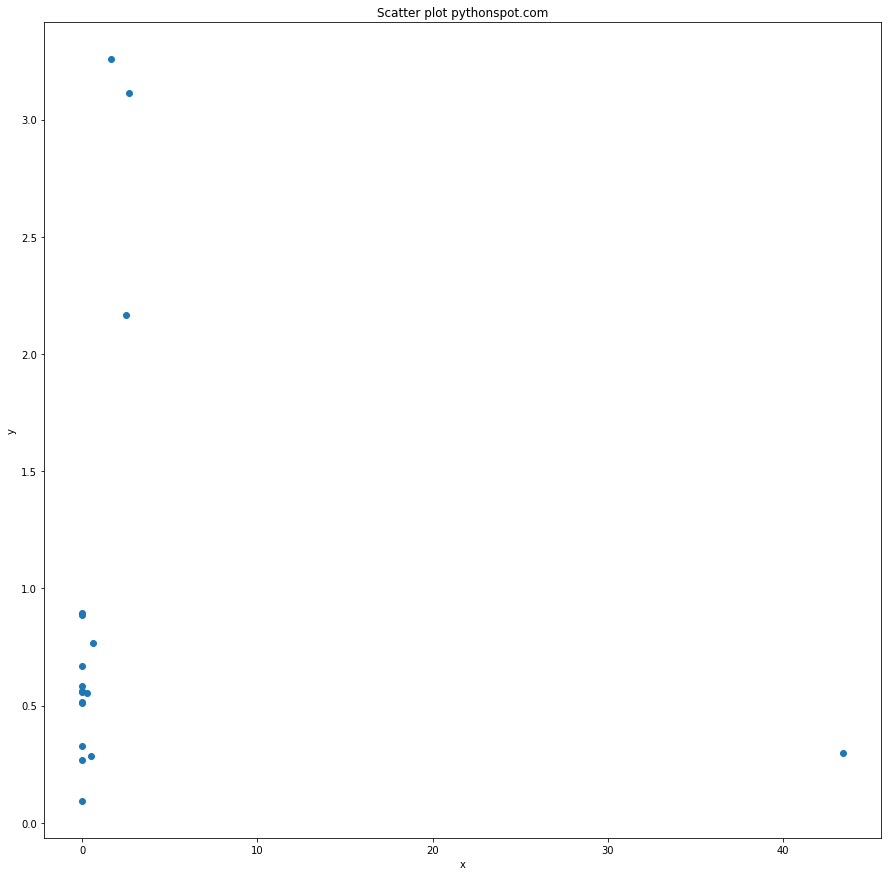

In [216]:
import matplotlib.pyplot as plt


# Plot
plt.scatter(y_train.iloc[:,2], y_pred.iloc[:,3])
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Decision Tree

In [225]:
modelTree = tree.DecisionTreeRegressor()
kfold_Tree = KFold(n_splits=2, shuffle=True, random_state = 331201) # Totalof batches

# Define our candidate hyperparameters
hp_candidates_Tree = [{'criterion': ['mse', 'friedman_mse', 'mae'],
                      'splitter' : ['best', 'random'],
                       'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
                       'max_features' : ['auto', 'sqrt', 'log2']}]

# Define all experiments
grid_Tree = GridSearchCV(estimator = modelTree, param_grid = hp_candidates_Tree, cv = kfold_Tree, scoring = 'neg_mean_squared_error')

In [226]:
save_stat = 'Tree_model_test.sav'

if os.path.isfile(save_stat): # Information recovery
    grid_Tree = joblib.load(save_stat)
else: # Training process
    grid_Tree.fit(X_train, y_train)#["Density_Theft_Bikes_in_2014-04-14/Area"]) 
    joblib.dump(grid_Tree, save_stat)

# Get the results
print(grid_Tree.best_score_)
print(grid_Tree.best_estimator_)
print(grid_Tree.best_params_)

-0.5666188547283529
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
{'criterion': 'mae', 'max_depth': 2, 'max_features': 'sqrt', 'splitter': 'best'}


In [227]:
best_Tree = grid_Tree.best_estimator_
y_pred = metrics_evaluation_prediction(best_Tree, X_test, y_test)

[[-0.52559994 -0.37836357 -0.28378687 -0.38972829 -0.42670498]
 [-0.52559994 -0.37836357 -0.28378687 -0.38972829 -0.42670498]
 [ 0.45968598 -0.37836357 -0.28378687 -0.38972829  0.15108682]
 [-0.56768365 -0.37836357  5.0072906  -0.38972829 -0.44215925]
 [ 0.45968598 -0.37836357 -0.28378687 -0.38972829  0.15108682]
 [-0.52559994 -0.37836357 -0.28378687 -0.38972829 -0.42670498]
 [-0.52559994 -0.37836357 -0.28378687 -0.38972829 -0.42670498]
 [-0.52559994 -0.37836357 -0.28378687 -0.38972829 -0.42670498]
 [-0.52559994 -0.37836357 -0.28378687 -0.38972829 -0.42670498]]
Mean Absolute Error: 0.7250446709546003
Mean Squared Error: 2.8037735985503485
Root Mean Squared Error: 1.674447251647644


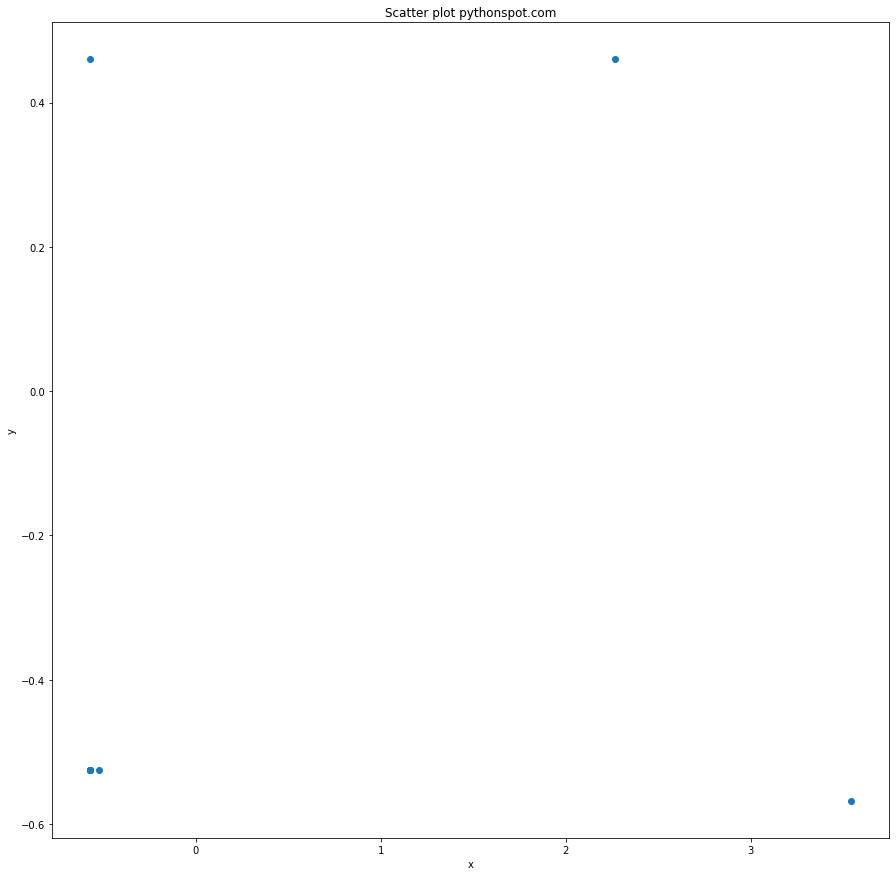

In [230]:
import matplotlib.pyplot as plt


# Plot
plt.scatter(y_test.iloc[:,0], y_pred.iloc[:,0])
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Super Vector Machine

In [89]:
SVR_algorithm = SVR(tol = 1e-5) # Tolerance by default
kfold_svr = KFold(n_splits=2, shuffle=True, random_state = 331201) # Totalof batches

# Define our candidate hyperparameters
hp_candidates_svm = [{'kernel': ['linear', 'poly',  'rbf', 'sigmoid'],
                      'gamma' : ['scale', 'auto']}]

# Define all experiments
grid_svm = GridSearchCV(estimator = SVR_algorithm, param_grid = hp_candidates_svm, cv = kfold_svr, scoring = 'neg_mean_squared_error')

In [128]:
save_stat = 'svr_model_test.sav'

for idx in y_train.columns.to_list():
  if os.path.isfile(save_stat): # Information recovery
      grid_svm = joblib.load(save_stat)
  else: # Training process
      grid_svm.fit(X_train, y_train) 
      joblib.dump(grid_svm, save_stat)

# Get the results
print(grid_svm.best_score_)
print(grid_svm.best_estimator_)
print(grid_svm.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (152, 5)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (152, 5)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (152, 5)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will

ValueError: ignored

In [125]:
best_svm = grid_svm.best_estimator_
#for idx in y_test.columns.to_list():
metrics_evaluation_prediction_svm(best_svm, X_test, y_test)


TypeError: ignored

# MLP Model

In general terms, we will evaluate different perceptron multi-layer architectures in order to obtain the best possible solution. We will use "brute force" methodology, training with the best possible combination of different neural network topologies. Of course, as long as processing times allow.

Let's start by dividing the training and validation sets into mini-batches, used in the training loop.

In [ ]:
# Convert data from tensor
batch_size = 1024; batch_datasets = {}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_datasets["train"] = TensorDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(np.expand_dims(y_train.values, axis = 1)).float())
batch_datasets["valid"] = TensorDataset(torch.from_numpy(X_valid.values).float(), torch.from_numpy(np.expand_dims(y_valid.values, axis = 1)).float())

dataloaders = {x: DataLoader(batch_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
# dataloaders = {}
# dataloaders["train"] = (torch.tensor(X_train.values), torch.tensor(np.expand_dims(y_train.values, axis = 1)))
# dataloaders["valid"] = (torch.tensor(X_valid.values), torch.tensor(np.expand_dims(y_valid.values, axis = 1)))
dataset_sizes = {x: len(batch_datasets[x]) for x in ['train', 'valid']}
print(device, dataset_sizes)

In [ ]:
# Declare a class for MLP (multilayer perceptron)
class MLP_nn(nn.Module):
    
    # class initialization
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(MLP_nn, self).__init__()
        # fully connected layer with linear activation
        self.fc0 = nn.Linear(input_size, hidden1_size)
        # fully connected layer with linear activation
        self.fc1 = nn.Linear(hidden1_size, hidden2_size)
        # fully connected layer with linear activation
        self.fc2 = nn.Linear(hidden2_size, output_size)
        # ReLu activation
        self.relu = nn.ReLU()
        # sigmoid activation
        self.sigmoid = nn.Sigmoid()
        
    # function to apply the neural network
    def forward(self, x):
        out = self.fc0(x)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        y_pred = self.sigmoid(out)
        return y_pred
    
# Create the neural network (2 input size for x1 and x2, 4 neurons in the first hidden layer, 4 neurons in the second hidden layer, and 1 output size for y)
MLP = MLP_nn(2, 4, 4, 1)

In [ ]:
## Architecture definition
class MLP_NN(nn.Module):
    def __init__(self, neurons, p = False):
        super(MLP_NN, self).__init__()
        layers = []
        for i, n in enumerate(neurons[:-1]):
            layers += [nn.Linear(n, neurons[i + 1])]
            if i + 1 < len(neurons) - 1:     
                layers += [nn.ReLU(inplace = False)]
                if p is not None: layers += [nn.Dropout(p = p, inplace = False)]

        self.architecture = nn.Sequential(*layers)

    def forward(self, x):
        return self.architecture(x)

In [ ]:
# Loss function: BCE = sum [-y log(y_pred) - (1 - y) log(1 - y_pred)]
criterion = nn.BCELoss()

# Optimizer: new_parameters = old_parameters - lr*gradient, with lr the learning rate
optimizer = torch.optim.SGD(MLP.parameters(), lr = 0.01)

In [ ]:
epochs = 50000 # number of epochs
losses = [] # list to stock the loss at each iteration

# Loop on epochs
for i in range(epochs):
    
    # compute the prediction using the previous parameters of the neural network
    y_pred = MLP.forward(torch.cat((x1, x2), dim=1))
    
    # compute and stock the loss
    loss = criterion(y_pred, y)
    losses.append(loss)
    
    # initialize the gradient to zero
    optimizer.zero_grad()
    
    # compute the gradient by back propagation
    loss.backward()
    
    # update the parameter values using the gradient
    optimizer.step()

In [ ]:
# Print the loss function
plot(range(epochs), losses)
title('Loss function', size=20)
xlabel('Epoch', size=20)
ylabel('Loss value', size=20)

In [ ]:
# Plot the results
Y_hat = MLP.forward(torch.cat((X1.reshape(10000, 1), X2.reshape(10000, 1)), dim=1))
Y_hat = Y_hat.reshape(X1.shape)
subplot(2, 2, 1)
scatter(x1, x2, c=y, cmap='bwr')
contourf(X1, X2, Y, cmap='bwr', alpha=0.5)
title('True model', size=20)
subplot(2, 2, 2)
scatter(x1, x2, c=y, cmap='bwr')
contourf(X1, X2, Y_hat.detach().numpy(), cmap='bwr', alpha=0.5)
title('Estimated model', size=20)
